In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

파싱

In [ ]:
def parsing(path):#파싱을 진행하는 함수
    with open(path,'r',encoding='utf-8') as f:#파일을 읽어드리고 ['로그','로그',...] 이런식으로 로그를 구조화
        train=[]
        para=""
        while True:
            l = f.readline() #한줄씩 읽어 옵니다

            if not l:
                break #파일을 전부 읽으면 읽기를 중단합니다.

            if l != "\n":
                para +=l
            else:
                if para!='':
                    if para[:4]=='POST': #Method가 POST인 경우 예외적으로 바디까지 가져옵니다.
                        para+=f.readline()
                    train.append(para)
                    para=""
    return train

In [ ]:
def dataset(path,mod='train'): #데이터셋을 생성합니다. 파싱한 데이터와 라벨을 생성합니다 
    x = parsing(f'{path}norm_{mod}.txt') # mod에 따라 train을 가져올지 test 데이터를 가져올지 결정됩니다.
    y = [0]*len(x) # 정상 라벨 0 을 정상 데이터 개수 만큼 생성
    x += parsing(f'{path}anomal_{mod}.txt')
    y += [1]*(len(x)-len(y)) # 비정상 라벨 1을 비정상 데이터 개수 만큼 생성
    return x, y

데이터 불러오기

In [ ]:
train_x, train_y = dataset('./','train')
test_x, test_y =  dataset('./','test')
print(f"train_x : {len(train_x)}")
print(f"train_y : {len(train_y)}")

train_x : 49167
train_y : 49167


In [ ]:
# 불러온 문자열들을 tokenizer를 이용해 키:값 쌍으로 바꿔준다.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x)
# 문자열을 값(index)로 바꿔준다.
train_x_index = tokenizer.texts_to_sequences(train_x)

In [ ]:
# 단어 -> 인덱스 키, 값 쌍
word_to_index = tokenizer.word_index
print(word_to_index)

{'5': 1, '0': 2, 'q': 3, '8': 4, 'accept': 5, 'xml': 6, 'cache': 7, 'text': 8, 'application': 9, 'x': 10, '1': 11, '3': 12, 'no': 13, 'localhost': 14, 'http': 15, 'gzip': 16, 'deflate': 17, 'utf': 18, '8080': 19, 'cookie': 20, '9': 21, 'like': 22, 'html': 23, 'control': 24, 'en': 25, 'user': 26, 'agent': 27, 'mozilla': 28, 'compatible': 29, 'konqueror': 30, 'linux': 31, 'khtml': 32, 'gecko': 33, 'pragma': 34, 'xhtml': 35, 'plain': 36, 'image': 37, 'png': 38, 'encoding': 39, 'charset': 40, 'language': 41, 'host': 42, 'jsessionid': 43, 'connection': 44, 'close': 45, 'tienda1': 46, 'jsp': 47, 'get': 48, 'content': 49, 'publico': 50, 'b1': 51, 'modo': 52, 'type': 53, 'www': 54, 'form': 55, 'urlencoded': 56, 'length': 57, 'post': 58, 'registro': 59, 'nombre': 60, 'login': 61, 'entrar': 62, 'miembros': 63, '2c': 64, 'imagenes': 65, 'ciudad': 66, 'registrar': 67, 'apellidos': 68, 'provincia': 69, 'password': 70, 'email': 71, 'direccion': 72, 'cp': 73, 'ntc': 74, 'dni': 75, 'precio': 76, 'carr

In [ ]:
rare_words = 0; # 등장 빈도수가 1회인 단어의 수
total_words = len(word_to_index); # 총 단어의 수
for key, value in tokenizer.word_counts.items():
  if(value<=1):
    rare_words += 1
print("전체 단어 수 : ", total_words)
print("등장 빈도수가 1회 이하인 단어의 수 : ", rare_words)

전체 단어 수 :  82923
등장 빈도수가 1회 이하인 단어의 수 :  54798


In [ ]:
#1회 이하인 단어는 제거한다.
tokenizer = Tokenizer(num_words = total_words - rare_words + 1)
tokenizer.fit_on_texts(train_x)
train_x_index = tokenizer.texts_to_sequences(train_x)
word_to_index = tokenizer.word_index

In [ ]:
# 한 http 정보의 최대 길이
max_length = max(len(i) for i in train_x_index)
print(max_length)

248


In [ ]:
# 훈련 데이터의 크기
train_x_pad = pad_sequences(train_x_index, maxlen=max_length)
print(train_x_pad.shape)

(49167, 248)


In [ ]:
# 단어 집합의 크기
vocab_size = len(word_to_index) + 1

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid')) # 활성 함수

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
train_y = np.array(train_y)
# 5%는 검증에 사용
history = model.fit(train_x_pad, train_y, epochs=7, batch_size=64, validation_split=0.05)

Epoch 1/7
730/730 [==============================] - 51s 68ms/step - loss: 0.2832 - acc: 0.8732 - val_loss: 0.2370 - val_acc: 0.9101
Epoch 2/7
730/730 [==============================] - 49s 67ms/step - loss: 0.0740 - acc: 0.9781 - val_loss: 0.1189 - val_acc: 0.9610
Epoch 3/7
730/730 [==============================] - 49s 67ms/step - loss: 0.0431 - acc: 0.9891 - val_loss: 0.1123 - val_acc: 0.9662
Epoch 4/7
730/730 [==============================] - 49s 68ms/step - loss: 0.0358 - acc: 0.9922 - val_loss: 0.0648 - val_acc: 0.9784
Epoch 5/7
730/730 [==============================] - 49s 67ms/step - loss: 0.0300 - acc: 0.9924 - val_loss: 0.0735 - val_acc: 0.9825
Epoch 6/7
730/730 [==============================] - 49s 67ms/step - loss: 0.0279 - acc: 0.9934 - val_loss: 0.1733 - val_acc: 0.9728
Epoch 7/7
730/730 [==============================] - 49s 67ms/step - loss: 0.0263 - acc: 0.9951 - val_loss: 0.0596 - val_acc: 0.9854


실제 정확도 확인

In [ ]:
test_x_index = tokenizer.texts_to_sequences(test_x)
test_x_pad = pad_sequences(test_x_index, maxlen = max_length)
test_y = np.array(test_y)
print("\n 테스트 정확도: %.4f" % (model.evaluate(test_x_pad, test_y)[1]))

385/385 [==============================] - 5s 13ms/step - loss: 0.0398 - acc: 0.9909

 테스트 정확도: 0.9909


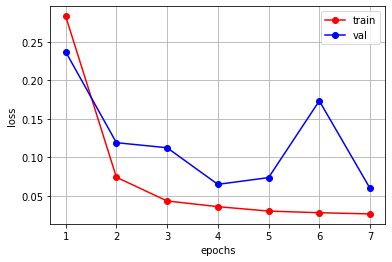

In [ ]:
# 훈련, 검증 loss 그래프
epochs = range(1, 8)
plt.plot(epochs, history.history['loss'], 'ro-')
plt.plot(epochs, history.history['val_loss'], 'bo-')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(True)
plt.show()